# Q table - SARSA and Q Learning
2020 Jérémie Decock

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/jdhp%2Fslides-rl/HEAD?filepath=labs%2Flab_rl4_policy_iteration.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/urls/gitlab.com/jdhp/slides-rl/-/raw/master/labs/lab_rl4_policy_iteration.ipynb/%3Finline)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://gitlab.com/jdhp/slides-rl/-/raw/master/labs/lab_rl4_policy_iteration.ipynb?inline=false)

**Notice**: Here we assume that the reward only depends on the state: $r(\state) \equiv \mathcal{R}(\state, \action, \state')$.

**Notice**: this notebook requires the OpenAI *Gym* library ; you can install it with `pip install gym` (the next cell does this for you if you use the Google Colab environment).

In [25]:
colab_requirements = [
    "matplotlib>=3.1.2",
    "numpy>=1.18.1",
    "nose>=1.3.7",
    "gym=>0.15.4",
]
import sys, subprocess
def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())
        
if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)

You can uncomment the following cell to install gym in MyBinder or in your local environment (remove only the `#` not the `!`).

In [26]:
#!pip install gym

In [27]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import math
import gym
import numpy as np
import copy
import pandas as pd
import seaborn as sns

In [28]:
sns.set_context("talk")

In [29]:
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

## Setup the FrozenLake toy problem with OpenAI Gym

For the purpose of focusing on the algorithms, we will use standard environments provided by OpenAI Gym framework.
OpenAI Gym provides controllable environments (https://gym.openai.com/envs/) for research in Reinforcement Learning.
We will use a simple toy problem to illustrate Dynamic Programming algorithms properties.

In this lab, we will try to solve the FrozenLake-v0 environment (https://gym.openai.com/envs/FrozenLake-v0/).
Additional information is available [here](https://github.com/openai/gym/wiki/FrozenLake-v0) and [here](https://github.com/openai/gym/wiki/FrozenLake-v0).

**Notice**: this environment is *fully observable*, thus here the terms (environment) *state* and (agent) *observation* are equivalent.
This is not always the case for example in poker, the agent doesn't know the opponent's cards.

### Get the FrozenLake state space and action space

In [30]:
env = gym.make('FrozenLake-v0')
env._max_episode_steps = 1000

Possible states in FrozenLake are:

In [31]:
states = list(range(env.observation_space.n))
states

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Possible actions are:

In [32]:
actions = list(range(env.action_space.n))
actions

[0, 1, 2, 3]

The following dictionary may be used to understand actions:

In [33]:
action_labels = {
    0: "Move Left",
    1: "Move Down",
    2: "Move Right",
    3: "Move Up"
}

### Display functions

The next cells contain functions that can be used to display states, transitions and policies with the FrozenLake environment.

In [34]:
def states_display(state_seq, title=None, figsize=(5,5), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds", ax=None):
    size = int(math.sqrt(len(state_seq)))
    state_array = np.array(state_seq)
    state_array = state_array.reshape(size, size)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)         # Sample figsize in inches

    sns.heatmap(state_array, annot=annot, fmt=fmt, linewidths=linewidths, square=square, cbar=cbar, cmap=cmap, ax=ax)
    
    if title is not None:
        plt.title(title)

    if ax is None:
        plt.show()
    else:
        return ax

In [35]:
def display_policy(policy):
    actions_src = ["{}={}".format(action, action_labels[action].replace("Move ", "")) for action in actions]
    title = "Policy (" + ", ".join(actions_src) + ")"
    states_display(policy, title=title, fmt="d", cbar=False, cmap="Reds")

In [36]:
def Qarray_display(q_array, title=None, figsize=(4,4), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds"):
    num_actions = q_array.shape[1]

    global_figsize = list(figsize)
    global_figsize[0] *= num_actions
    fig, ax_list = plt.subplots(ncols=num_actions, figsize=global_figsize)   # Sample figsize in inches

    for action_index in range(num_actions):
        ax = ax_list[action_index]
        state_seq = q_array.T[action_index]
        states_display(state_seq, title=None, figsize=figsize, annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds", ax=ax)

    plt.suptitle(title)
    plt.show()

## Exercise: Implement the SARSA algorithm

In [37]:
def greedy_policy(state, q_array):

    action = np.argmax(q_array[state, :])

    return action

In [38]:
def epsilonGreedy(state, Q_table, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(low=min(actions), high=max(actions)+1)
    else:
        return np.argmax(Q_table[state, :])

In [39]:
Q_table_history = []
alpha_history = []
def sarsa(gamma=0.99, alpha=0.5, alpha_factor=0.9995, epsilon=0.5, NUM_EPISODES=10000):
    num_states = len(states)
    num_actions = len(actions)
    Q_table = np.zeros([num_states, num_actions])
    
    
    for episode_index in range(NUM_EPISODES):
        state = env.reset()
        action = epsilonGreedy(state, Q_table, epsilon)
        Q_table_history.append(Q_table.copy())
        alpha_history.append(alpha)
        
        alpha = alpha * alpha_factor
        done = False 
        while not done:
            state_2, reward, done, info = env.step(action)
            action_2 = epsilonGreedy(state_2, Q_table, epsilon)
            Q_table[state][action] = Q_table[state][action] + alpha * (reward + gamma * Q_table[state_2][action_2] - Q_table[state][action])
            state = state_2
            action = action_2
            
    env.close()
            
    return Q_table

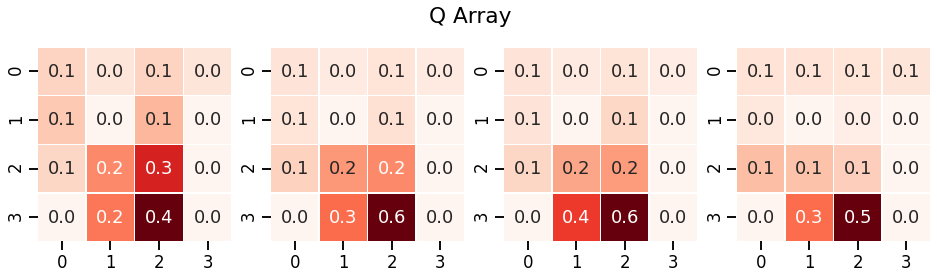

In [40]:
Q_array = sarsa()
Qarray_display(Q_array, title="Q Array", cbar=True)

In [41]:
Q_table_history = np.array(Q_table_history)
df_q_hist_list = []

for action_index in range(Q_table_history.shape[2]):
    df_q_hist_list.append(pd.DataFrame(Q_table_history[:, :, action_index]))

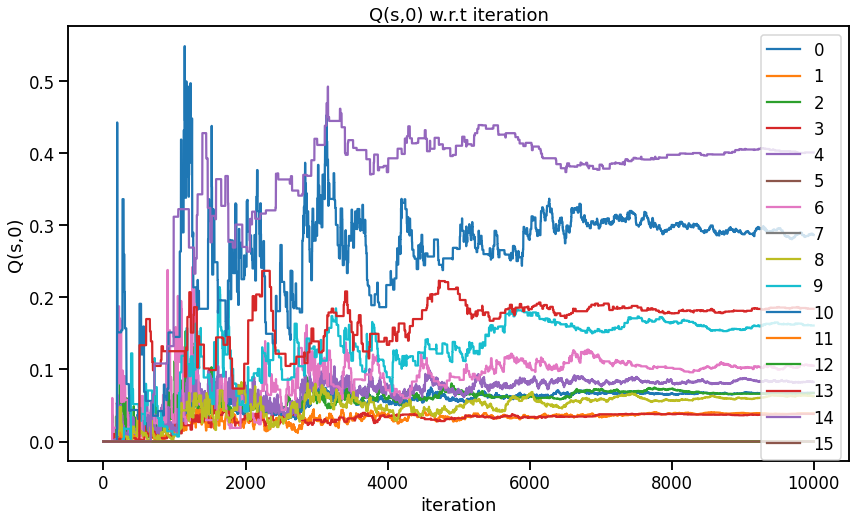

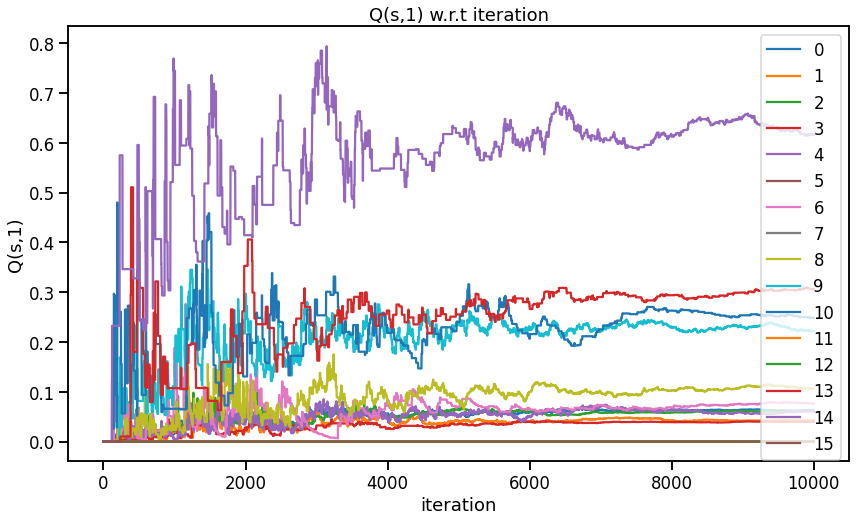

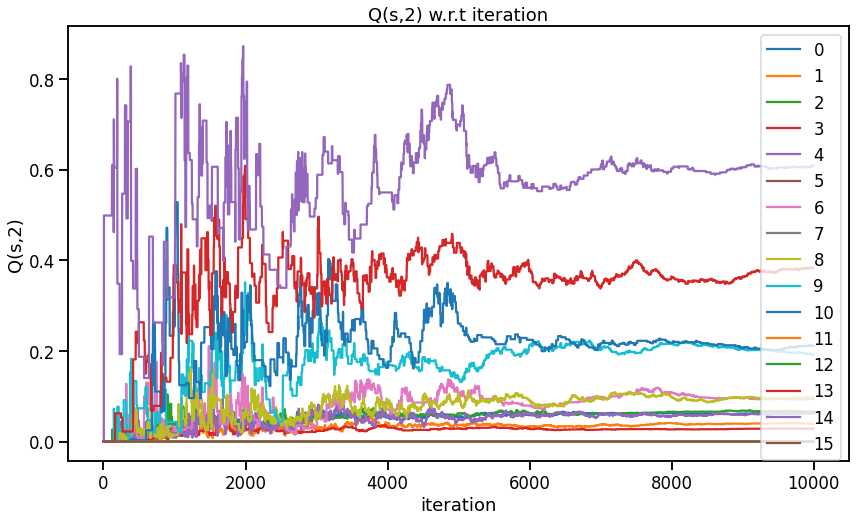

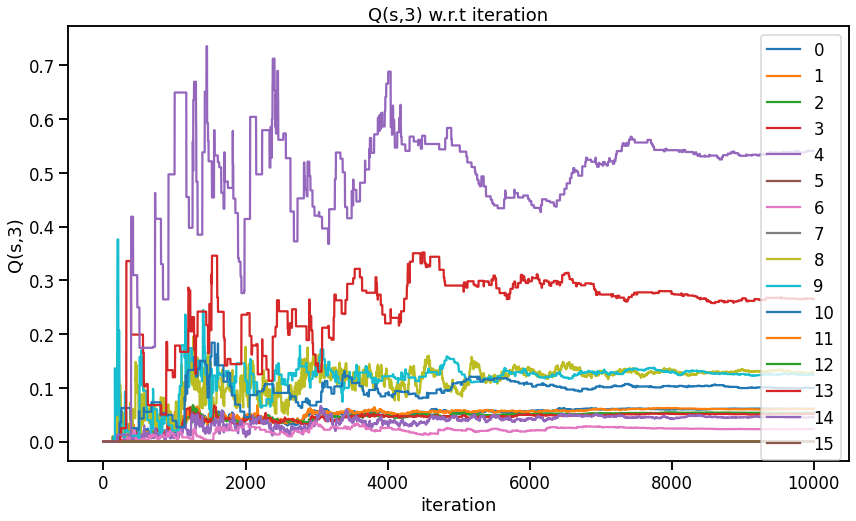

In [42]:
for action_index, df_q_hist in enumerate(df_q_hist_list):
    df_q_hist.plot(figsize=(14,8))
    plt.title("Q(s,{}) w.r.t iteration".format(action_index))
    plt.ylabel("Q(s,{})".format(action_index))
    plt.xlabel("iteration")
    plt.legend(loc='upper right');

In [45]:
environment = gym.make('FrozenLake-v0')
environment._max_episode_steps = 1000

reward_list = []
NUM_EPISODE = 1000

for episode_index in range(NUM_EPISODE):
    state = environment.reset()
    done = False
    
    #t = 0

    while not done:
        #action = epsilon_greedy_policy(state, q_array, epsilon)
        action = greedy_policy(state, Q_array)
        state, reward, done, info = environment.step(action)

    reward_list.append(reward)

reward_df = pd.DataFrame(reward_list)

print('Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1):', np.average(reward_df))

environment.close()

Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1): 0.788


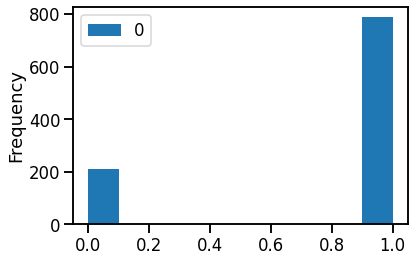

In [46]:
reward_df.plot.hist();

## Exercise: Implement the Q_learning algorithm

In [53]:
q_array_history = []
alpha_history = []
def q_learning(alpha=0.1, alpha_factor=0.9995, gamma=0.99, epsilon=0.5, num_episodes=10000):
    num_states = environment.observation_space.n
    num_actions = environment.action_space.n
    q_array = np.zeros([num_states, num_actions])   # Initial Q table

    
    for episode_index in range(num_episodes):
        state = env.reset()
        q_array_history.append(q_array.copy())
        alpha_history.append(alpha)
        done = False
        alpha = alpha * alpha_factor

        while not done:
            action = epsilonGreedy(state, q_array, epsilon)
            state_2, reward, done, info = env.step(action)
            q_array[state][action] = q_array[state][action] + alpha * (reward + gamma * q_array[state_2][:].max() - q_array[state][action])
            state = state_2
        
            
    return q_array

In [ ]:
def find_policy(gamma, alpha, epsilon, NUM_EPISODES, algo=Q_learning):
    Q_table = algo(gamma, alpha, epsilon, NUM_EPISODES)
    policy = np.random.randint(low=min(actions), high=max(actions), size=len(states), dtype='int')
    for state in states:
        policy[state] = Q_table[state][:].argmax()
    
    return policy

### Test Q_learning algo

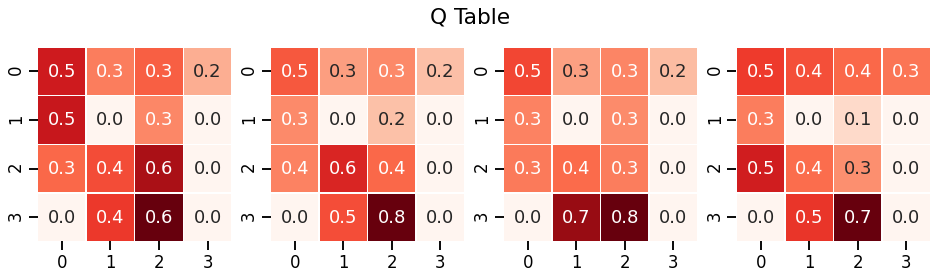

In [54]:
q_array = q_learning()


Qarray_display(q_array, title="Q Table", cbar=True)

### Test SARSA algo

In [55]:
q_array_history = np.array(q_array_history)
df_q_hist_list = []

for action_index in range(q_array_history.shape[2]):
    df_q_hist_list.append(pd.DataFrame(q_array_history[:, :, action_index]))

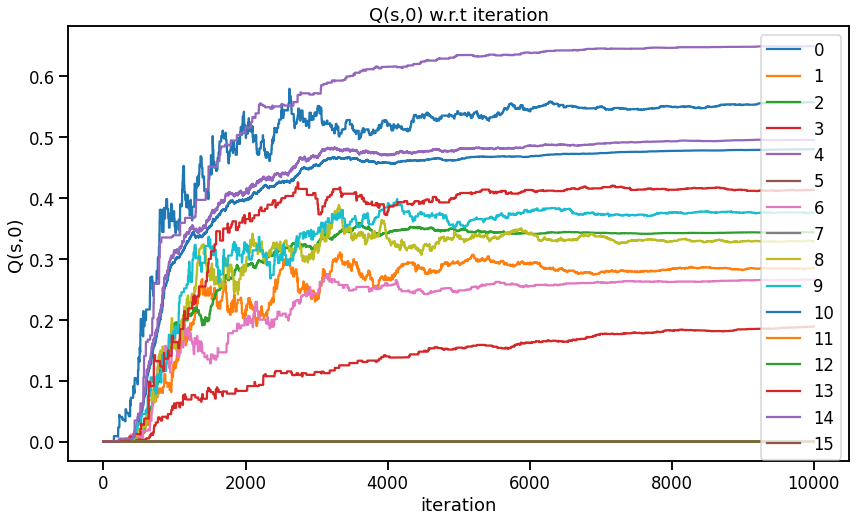

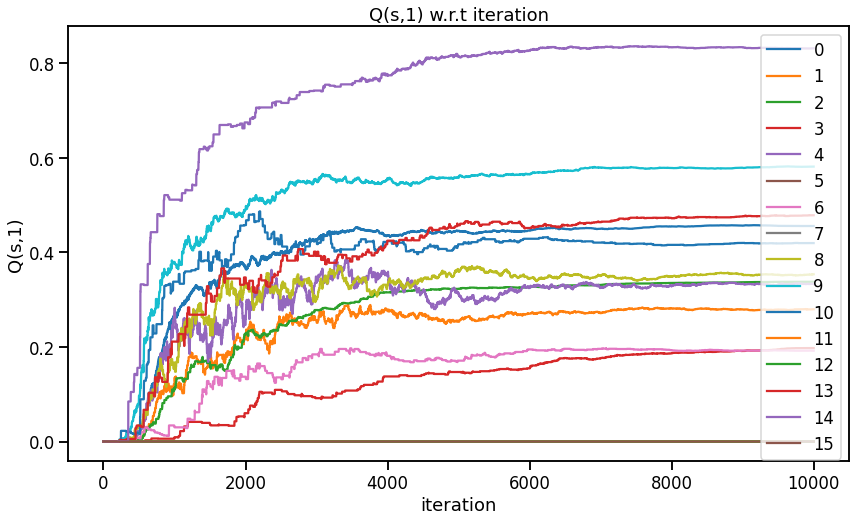

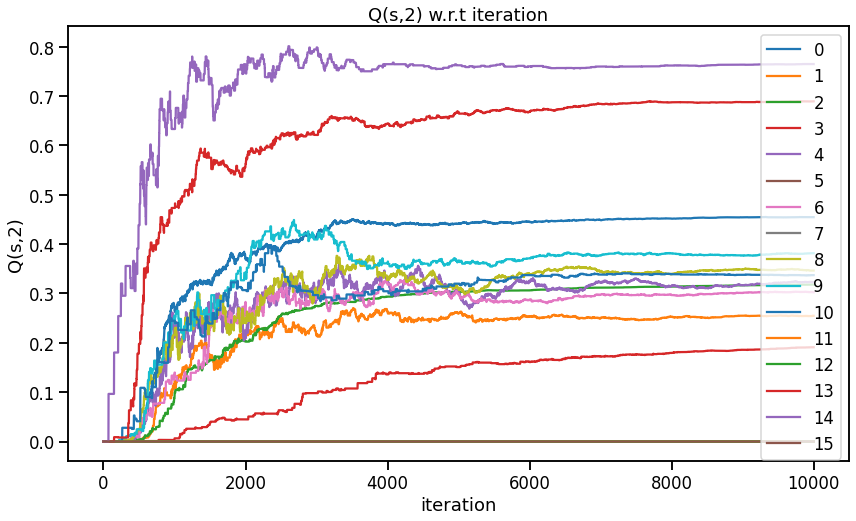

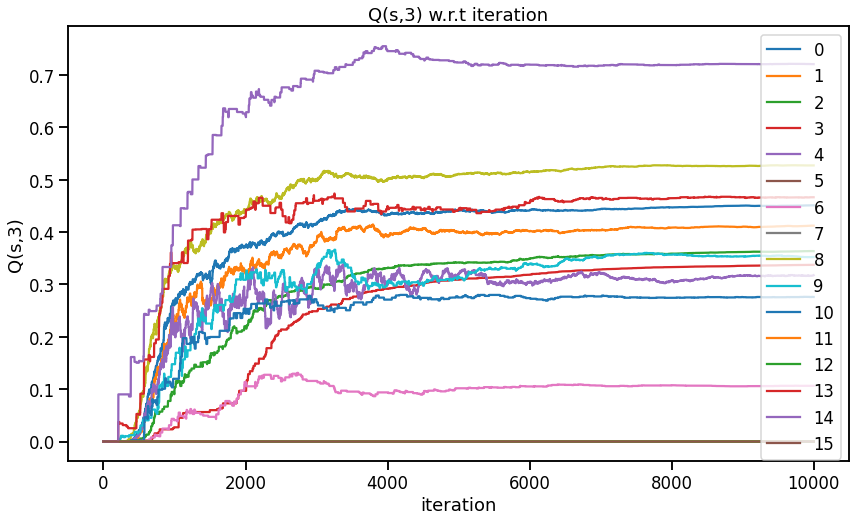

In [56]:
for action_index, df_q_hist in enumerate(df_q_hist_list):
    df_q_hist.plot(figsize=(14,8))
    plt.title("Q(s,{}) w.r.t iteration".format(action_index))
    plt.ylabel("Q(s,{})".format(action_index))
    plt.xlabel("iteration")
    plt.legend(loc='upper right');

### Evaluate with Gym (single trial)

In [57]:
reward_list = []
NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state = environment.reset()
    done = False
    #t = 0

    while not done:
        #action = epsilon_greedy_policy(state, q_array, epsilon)
        action = greedy_policy(state, q_array)
        state, reward, done, info = environment.step(action)

    reward_list.append(reward)

reward_df = pd.DataFrame(reward_list

print('Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1):', np.average(reward_df))

environment.close()

Average reward (which is equivalent to a "success rate" in the FrozenLake environment as the total rewards in this environment are either 0 or 1): 0.834


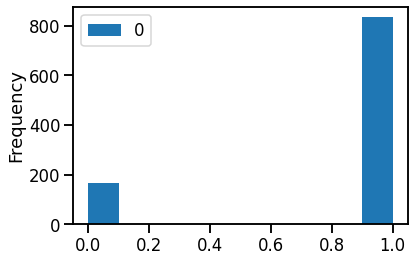

In [58]:
reward_df.plot.hist();